In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

print('TensorFlow', tf.__version__)

TensorFlow 2.0.0


In [2]:
tfrecords_base_dir = '../tfrecords'
BATCH_SIZE = 1
H, W = 720, 1280
autotune = tf.data.experimental.AUTOTUNE
class_map = {value: idx for idx, value in enumerate(['bus',
                                                     'traffic light',
                                                     'traffic sign',
                                                     'person',
                                                     'bike',
                                                     'truck',
                                                     'motor',
                                                     'car',
                                                     'train',
                                                     'rider'])}
num_classes = len(class_map)

In [3]:
@tf.function
def flip_data(image, boxes, w):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([
            w - boxes[:, 2],
            boxes[:, 1],
            w - boxes[:, 0],
            boxes[:, 3]
        ], axis=-1)
    return image, boxes


@tf.function
def random_jitter(image):
    # ToDo
    pass

def imshow(image):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    plt.imshow(image)
    
    
def draw_boxes_cv2(image, bbox_list, model_input_shape=[H, W]):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    h, w = img.shape[:2]
    h_scale, w_scale = h / H, w / W
    bbox_list = np.int32(bbox_list * np.array([w_scale, h_scale] * 2))
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [30, 15, 200], 2)
    return img

def compute_area(boxes):
    h_ = boxes[:, 2] - boxes[:, 0]
    w_ = boxes[:, 3] - boxes[:, 1]
    return h_ * w_

def compute_feature_sizes(H, W):
    fm_sizes = []
    for i in range(3, 8):
        stride = 2.**i
        fm_sizes.append([tf.math.ceil(H / stride), tf.math.ceil(W / stride), stride])
    return fm_sizes
        
def get_centers(fm_h, fm_w, stride=None):
    rx = (tf.range(fm_w) + 0.5) * (stride)
    ry = (tf.range(fm_h) + 0.5) * (stride)
    sx, sy = tf.meshgrid(rx, ry)
    cxy = tf.stack([sx, sy], axis=-1)
    return cxy

def get_all_centers(H, W):
    centers_list = []
    feature_sizes = compute_feature_sizes(H, W)
    for fm_h, fm_w, stride in feature_sizes:
        cyx = get_centers(fm_h, fm_w, stride)
        cyx = tf.reshape(cyx, shape=[-1, 2])
        centers_list.append(cyx)
    return centers_list

@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
    tf.TensorSpec(shape=[None, 5], dtype=tf.float32),
    tf.TensorSpec(shape=[], dtype=tf.float32),
    tf.TensorSpec(shape=[], dtype=tf.float32)
])
def compute_targets_(centers, labels, low, high):
    '''
        From the FCOS paper, "Specifically, location (x, y) is
        considered as a positive sample if it falls into any 
        ground-truth box and the class label c∗ of the location is
        the class label of the ground-truth box. Otherwise it is a
        negative sample and c ∗ = 0 (background class)
        Besides the label for classification, we also have a 4D
        real vector t∗ = (l∗, t∗, r∗, b∗) being the regression
        targets for the location. Here l∗, t∗, r∗ and b∗ are the
        distances from the location to the four sides of the bounding
        box ...If a location falls into multiple bounding boxes, it is
        considered as an ambiguous sample. We simply choose the
        bounding box with minimal area as its regression target.
        ...we firstly compute the regressiontargets l∗, t∗, r∗ and b∗
        for each location on all feature levels. Next, if a location
        satisfies max(l∗, t∗, r∗, b∗) > mi or max(l∗, t∗, r∗, b∗) < mi−1,
        it is set as a negative sample and is thus not required to
        regress a bounding box anymore. Here mi is the maximum distance
        that feature level i needs to regress. In this work, m2, m3, m4,
        m5, m6 and m7 are set as 0, 64, 128, 256, 512 and ∞, respectively"
        Args:
            centers (M, 2): Centers for the current feature level 
            labels (N, 5):  All labels for the current image
            low: Lower limit for ltrb value for the current feature level
            high: Upper limit for ltrb value for the current feature level
    '''
    boxes_ = labels[:, :4]
    class_ids_ = labels[:, 4]
    
    # Sorted the boxes by area in ascending order so that
    # we pick the smallest box when computing ltbr values
    areas = compute_area(boxes_)
    sorted_indices = tf.argsort(areas)
    boxes = tf.gather(boxes_, indices=sorted_indices)
    class_ids = tf.gather(class_ids_, indices=sorted_indices)
    
    xy_min_ = boxes[:, :2]
    xy_max_ = boxes[:, 2:]
    lt_ = centers[:, None] - xy_min_
    rb_ = xy_max_ - centers[:, None]
    ltrb_ = tf.concat([lt_, rb_], axis=2) # (M, N, 4)
    
    # check if max(lbtr) lies in the valid_range for this
    # feature level
    max_ltrb_ = tf.reduce_max(ltrb_, axis=2) # (M, N)
    mask_ltrb_size = tf.logical_and(max_ltrb_ > low, max_ltrb_ < high)
    
    mask_lt = tf.logical_and(ltrb_[:, :, 0] > 0, ltrb_[:, :, 1] > 0)
    mask_rb = tf.logical_and(ltrb_[:, :, 2] > 0, ltrb_[:, :, 3] > 0)
    mask = tf.logical_and(mask_lt, mask_rb) 
    mask = tf.logical_and(mask, mask_ltrb_size) # (M, N)
    
    mask = tf.cast(mask, dtype=tf.float32)
    fg_mask = tf.reduce_sum(mask, axis=1) != 0 # (M,)
    fg_mask = tf.cast(fg_mask, dtype=tf.float32)
    fg_mask = tf.tile(fg_mask[:, None], multiples=[1, 4])

    valid_indices = tf.argmax(mask, axis=1) # (M, )
    matched_boxes = tf.gather(boxes, valid_indices)
    matched_class_ids = tf.gather(class_ids, valid_indices) + 1
    
    x_min, y_min, x_max, y_max = tf.split(matched_boxes, 
                                         num_or_size_splits=4,
                                         axis=1)
    l = tf.abs(centers[:, 0] - x_min[:, 0])
    t = tf.abs(centers[:, 1] - y_min[:, 0])
    r = tf.abs(x_max[:, 0] - centers[:, 0])
    b = tf.abs(y_max[:, 0] - centers[:, 1])
    lr = tf.stack([l, r], axis=1)
    tb = tf.stack([t, b], axis=1)
    
    min_lr = tf.reduce_min(lr, axis=1)
    max_lr = tf.reduce_max(lr, axis=1)
    min_tb = tf.reduce_min(tb, axis=1)
    max_tb = tf.reduce_max(tb, axis=1)
    
    classification_target = matched_class_ids * fg_mask[:, 0]
    centerness_target = tf.sqrt((min_lr/max_lr) * (min_tb/max_tb)) * fg_mask[:, 0]
    regression_target = tf.stack([l, t, r, b], axis=1) * fg_mask
    
    return classification_target, centerness_target, regression_target


@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 5], dtype=tf.float32)
])
def compute_targets(labels):
    centers_list = get_all_centers(H, W)
    m = [
        [0.0, 64.0],
        [64.0, 128.0],
        [128.0, 256.0],
        [256.0, 512.0],
        [512.0, 1e8]]
    classification_target = []
    centerness_target = []
    regression_target = []
    for i in range(5):
        centers = centers_list[i]
        low, high = m[i]
        cls_target, \
        ctr_target, \
        reg_target = compute_targets_(centers, labels, low, high)
        
        classification_target.append(cls_target)
        centerness_target.append(ctr_target)
        regression_target.append(reg_target)
        
    classification_target = tf.concat(classification_target, axis=0)
    centerness_target = tf.concat(centerness_target, axis=0)
    regression_target = tf.concat(regression_target, axis=0)
    return classification_target, centerness_target, regression_target

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}

@tf.function
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(
        example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    bboxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs'])
    ], axis=-1)
    class_ids = tf.reshape(tf.sparse.to_dense(
        parsed_example['labels']), [-1, 1])
    return image, bboxes, class_ids

def load_data(input_shape):
    h, w = input_shape
    @tf.function
    def load_data_(example_proto, input_shape=input_shape):
        image, boxes_, class_ids = parse_example(example_proto)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, size=[h, w])
        boxes = tf.stack([
            tf.clip_by_value(boxes_[:, 0] * w, 0, w),
            tf.clip_by_value(boxes_[:, 1] * h, 0, h),
            tf.clip_by_value(boxes_[:, 2] * w, 0, w),
            tf.clip_by_value(boxes_[:, 3] * h, 0, h)
        ], axis=-1)
        image, boxes = flip_data(image, boxes, w)
        label = tf.concat([boxes, class_ids], axis=-1)
        classification_target, centerness_target, regression_target = \
            compute_targets(label)
        return image, (classification_target, centerness_target, regression_target)
    return load_data_

In [5]:
options = tf.data.Options()
options.experimental_deterministic = False
train_files = tf.data.Dataset.list_files('{}/train*'.format(tfrecords_base_dir))
train_dataset = train_files.interleave(tf.data.TFRecordDataset,
                                       cycle_length=16,
                                       block_length=16,
                                       num_parallel_calls=autotune)
train_dataset = train_dataset.map(
    load_data([H, W]), num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(512)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
train_dataset = train_dataset.prefetch(autotune)
train_dataset = train_dataset.with_options(options)
tf.data.experimental.get_structure(train_dataset)

(TensorSpec(shape=(1, 720, 1280, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(1, 19220), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 19220), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 19220, 4), dtype=tf.float32, name=None)))

In [6]:
def ltrb2boxes(centers, ltbr):  
    boxes = tf.concat([
        centers - ltbr[:, :2],
        centers + ltbr[:, 2:]], axis=-1)
    return boxes

def decode_predictions(cls_target,
                       ctr_target,
                       reg_target, 
                       score_threshold=0.0):
    centers_list = get_all_centers(H, W)
    centers = tf.concat(centers_list, axis=0)
    cls_scores = tf.reduce_max(cls_target[0], axis=1)
    cls_ids = tf.argmax(cls_target[0], axis=1)
    score_map = cls_scores * ctr_target[0]

    valid_indices = tf.where(score_map > score_threshold)[:, 0]

    valid_scores = tf.gather(score_map, valid_indices)
    valid_cls_ids = tf.gather(cls_ids, valid_indices)
    valid_centers = tf.gather(centers, valid_indices)
    valid_ltrb = tf.gather(reg_target[0], valid_indices)

    decoded_boxes = ltrb2boxes(valid_centers, valid_ltrb)
    nms_indices = tf.image.non_max_suppression(decoded_boxes,
                                               valid_scores, 
                                               max_output_size=300)
    boxes = tf.gather(decoded_boxes, nms_indices)
    scores = tf.gather(valid_scores, nms_indices)
    ids = tf.gather(valid_cls_ids, nms_indices)
    return boxes, scores, ids

Number of positive centers: 567.0



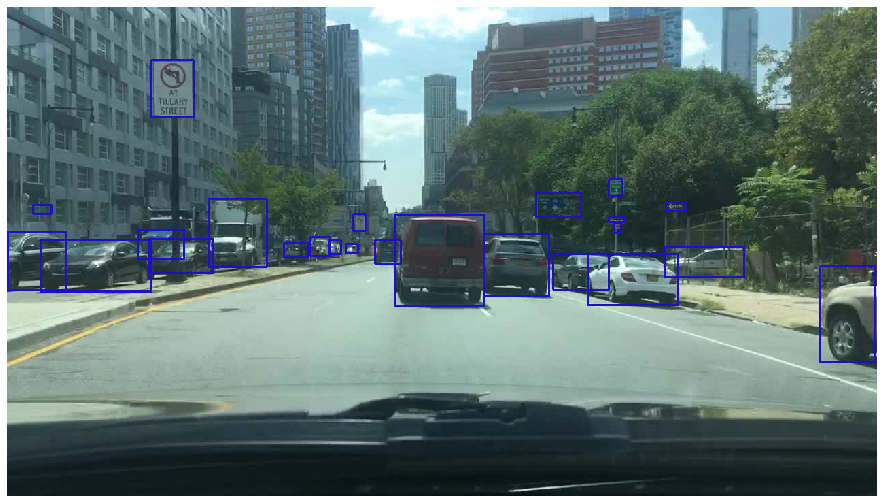

In [7]:
for batch in tqdm(train_dataset.take(1)):
    image, (cls_target, ctr_target, reg_target) = batch
    cls_target = tf.cast(cls_target, dtype=tf.int32)
    positive_centers = tf.reduce_sum(tf.cast(cls_target != 0,
                                             dtype=tf.float32))
    cls_target = tf.one_hot(cls_target, depth=num_classes+1)
    cls_target = cls_target[:, :, 1:]
    
    print('Number of positive centers: {}'.format(positive_centers.numpy()))
    boxes, scores, ids = decode_predictions(cls_target,
                                            ctr_target,
                                            reg_target, 
                                            score_threshold=0.05)
    image = np.uint(image[0])
    boxes = boxes.numpy()
    image = draw_boxes_cv2(image, boxes)
    imshow(image)